# Mitchell Pudil
# Homework 4: Costa Rica Poverty Classification

# 4.1 Cleaning the Data
## 4.1.1 Importing Necessary Packages

In [2]:
# Importing for graphing and looking at data

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Don't show warnings (for presentation purposes)
import warnings
warnings.filterwarnings('ignore')


## 4.1.2 Downloading the Data 

In [3]:
train = pd.read_csv("/Users/mitchellpudil/Desktop/all/train.csv")  # Import dataset from csv
train.head()   # Look at head of training data

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


## 4.1.3: Plot Target 

([<matplotlib.axis.XTick at 0x10dacdd30>,
 <a list of 4 Text xticklabel objects>)

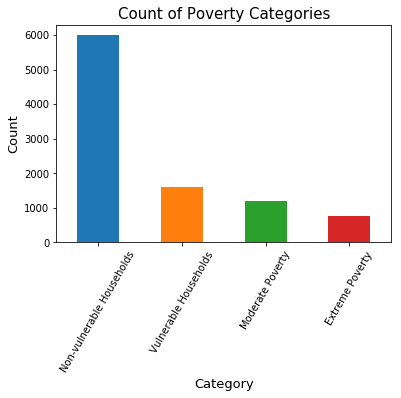

In [4]:
fig = train['Target'].value_counts().plot(kind='bar')
plt.xlabel('Category', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.title('Count of Poverty Categories', fontsize=15)
plt.xticks([0,1,2,3],
          ['Non-vulnerable Households',  'Vulnerable Households', 
           'Moderate Poverty', 'Extreme Poverty'], rotation=60)

### In some cases, it may prove necesary to use sampling techniques to attempt to even out the categories. Here, however, while we the "Non-vulnerable Households" section is oversampled, we will not resample or delete some observations because we have useful information about how likely it is for a certain house to be non-vulnerable.

## 4.1.4: Missing Data

Text(0.5,1,'Percent missing data by feature')

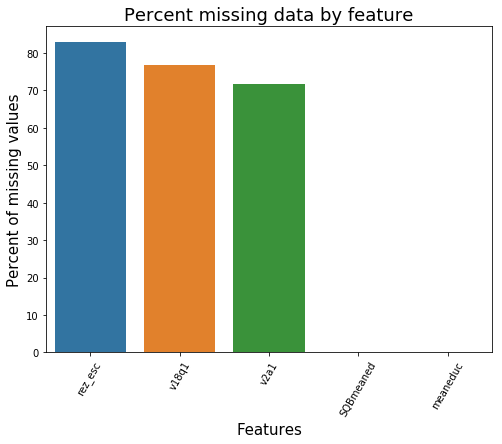

In [5]:
# Graph Missing data

#Calculate missing data
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(30)

#Graph missing data as histogram
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='60')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=18)

### It appears there are only 5 features with missing variables:
### 1. Years behind in school (rez_esc). Note that this is only defined for people between the ages of 7 and 18 
### 2. Number of tablets household owns (v18q1): Note that value is 0 if the family does not own a tablet.
### 3. Monthly rent payment (v2a1): Missing if owns are paid off (they have bought their house), precarious, or other
### 4. Square of the mean years of education of adults >=18 in the household (SQBmeaned)
### 5. Average years of education for adults 18+ (meaneduc)

### We will now fill in missing data.

### For years behind in school, we will use the mean if the person is between 7 and 18 years old. Otherwise, we will put a 0.

In [6]:
# If individual is within the 7-18 bound, use mean
train.loc[((train['age'] > 6) & (train['age'] < 19)) & (train['rez_esc'].isnull()), 'rez_esc'] = 0

# If individual is beyond those bounds, set to 0
train['rez_esc'] = train['rez_esc'].fillna(0)

### For monthly tablets owned, set to 0 if missing

In [7]:
train['v18q1'] = train['v18q1'].fillna(0)

### For monthly rent payment, let's distinguish between people who own a house and others.

In [8]:
# For people who own their own home, tipovivi1 =1 
train.loc[(train['tipovivi1']==1), 'v2a1']=0

# For others, just use mean
def mean_it(feature):
    mean_var = train[feature].mean()
    train[feature] = train[feature].fillna(mean_var)
    
mean_it('v2a1')

### For adult education missing variables, we'll just use the mean

In [9]:
mean_it('SQBmeaned')
mean_it('meaneduc')

## 4.1.5: Identify errors (where each member in the family does not have the same target)

In [10]:
# Groupby the household and figure out the number of unique values
all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

# Households where targets are not all equal
not_equal = all_equal[all_equal != True]

print('There are {} households where the family members do not all have the same target.'.format(len(not_equal)))


There are 85 households where the family members do not all have the same target.


### For these families, we will use the head of the household's target as the target for the family.

In [11]:
for household in not_equal.index:
    true_target = int(train[(train['idhogar'] == household) & (train['parentesco1'] == 1.0)]['Target'])
    train.loc[train['idhogar'] == household, 'Target'] = true_target
    all_equal = train.groupby('idhogar')['Target'].apply(lambda x: x.nunique() == 1)

    
#check_errors()  # Double check that there are now no families with different targets

### Most people are not behind in school and are well off. 

## 4.1.6: Feature Engineering

### To begin feature engineering, let's construct a feature for overall house quality

In [12]:
train['casa_calidad'] = train['cielorazo'] + (1- train['pisonotiene']) + (1-train['abastaguano']) + (1- train['noelec']) + (1- train['sanitario1']) + (1-train['energcocinar1']) + train['epared3']     

Text(0.5,1,'Calidades de Casa')

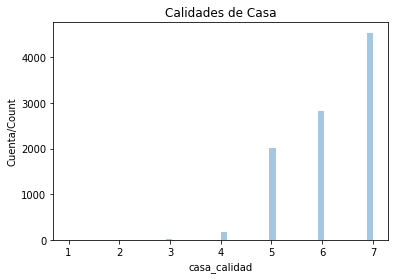

In [13]:
sns.distplot(train.casa_calidad, kde=False) #kde is kernel density estimate. 
plt.ylabel('Cuenta/Count')
plt.title('Calidades de Casa')

### We will also be needing to know the number of "luxury" goods that are available within the household (this will mainly come in handy when we look for outliers, but also for modeling the data).

In [14]:
train['luxury'] = train['v18q1'] + train['refrig'] + train['television'] + train['qmobilephone'] + train['computer']

### Per Capita Features

In [15]:
def pc_feature(feature):
    pc_feature = train[feature] / train['tamviv']
    return pc_feature


train['tablet_pc'] = pc_feature('v18q1')
train['refrig_pc'] = pc_feature('refrig')
train['television_pc'] = pc_feature('television')
train['qmobilephone_pc'] = pc_feature('qmobilephone')
train['computer_pc'] = pc_feature('computer')

### To help us with correlations, let's separate categorical, numeric, and transformed (like squared) features for individuals and households.

In [16]:
# Individual Data
ind_bool = ['v18q', 'dis', 'male', 'female', 'estadocivil1', 'estadocivil2', 'estadocivil3', 
            'estadocivil4', 'estadocivil5', 'estadocivil6', 'estadocivil7', 
            'parentesco1', 'parentesco2',  'parentesco3', 'parentesco4', 'parentesco5', 
            'parentesco6', 'parentesco7', 'parentesco8',  'parentesco9', 'parentesco10', 
            'parentesco11', 'parentesco12', 'instlevel1', 'instlevel2', 'instlevel3', 
            'instlevel4', 'instlevel5', 'instlevel6', 'instlevel7', 'instlevel8', 
            'instlevel9', 'mobilephone']
ind_cont = ['rez_esc', 'escolari', 'age', 'tablet_pc', 'refrig_pc', 'television_pc', 'qmobilephone_pc','computer_pc']


In [17]:
# Household Data
hh_bool = ['hacdor', 'hacapo', 'v14a', 'refrig', 'paredblolad', 'paredzocalo', 
           'paredpreb','pisocemento', 'pareddes', 'paredmad',
           'paredzinc', 'paredfibras', 'paredother', 'pisomoscer', 'pisoother', 
           'pisonatur', 'pisonotiene', 'pisomadera',
           'techozinc', 'techoentrepiso', 'techocane', 'techootro', 'cielorazo', 
           'abastaguadentro', 'abastaguafuera', 'abastaguano',
            'public', 'planpri', 'noelec', 'coopele', 'sanitario1', 
           'sanitario2', 'sanitario3', 'sanitario5',   'sanitario6',
           'energcocinar1', 'energcocinar2', 'energcocinar3', 'energcocinar4', 
           'elimbasu1', 'elimbasu2', 'elimbasu3', 'elimbasu4', 
           'elimbasu5', 'elimbasu6', 'epared1', 'epared2', 'epared3',
           'etecho1', 'etecho2', 'etecho3', 'eviv1', 'eviv2', 'eviv3', 
           'tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5', 
           'computer', 'television', 'lugar1', 'lugar2', 'lugar3',
           'lugar4', 'lugar5', 'lugar6', 'area1', 'area2']

hh_ordered = [ 'rooms', 'r4h1', 'r4h2', 'r4h3', 'r4m1','r4m2','r4m3', 'r4t1',  'r4t2', 
              'r4t3', 'v18q1', 'tamhog','tamviv','hhsize','hogar_nin',
              'hogar_adul','hogar_mayor','hogar_total',  'bedrooms', 'qmobilephone']

hh_cont = ['v2a1', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'overcrowding']

In [18]:
sqr_var = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']


## 4.1.7:  Drop ID

In [19]:
# Drop id
train = train.drop(['Id', 'idhogar'], axis=1)

## 4.1.8 Identifying and Removing Outliers and "Bad" Features

In [20]:
# The following code comes from Will Koehrsen and is used for plotting easy-to-read categorical variables against 
# each other. It has been modified to fit the needs of the project. Essentially, it takes two features and a dataset
# and plots the features against each other. We will be using this to determine outliers and drop them if necessary.

def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize=18,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 13)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}", fontsize=20); plt.ylabel(f"{y}", fontsize=15); plt.title(f"{y} vs {x}", fontsize=18);

### Outliers we will look for include: 
### 1. Impoverished but have many "luxury" goods (we may not look at house quality because these are pretty basic necessities we included, so it is expected that even low-income families will have at least most of the house quality requirements set).
### 2. Wealthy but few "luxury" goods or low house quality
### 3. Wealthy and an unusual amount of luxury goods

Text(0.5,1,'Poverty Level vs House Quality')

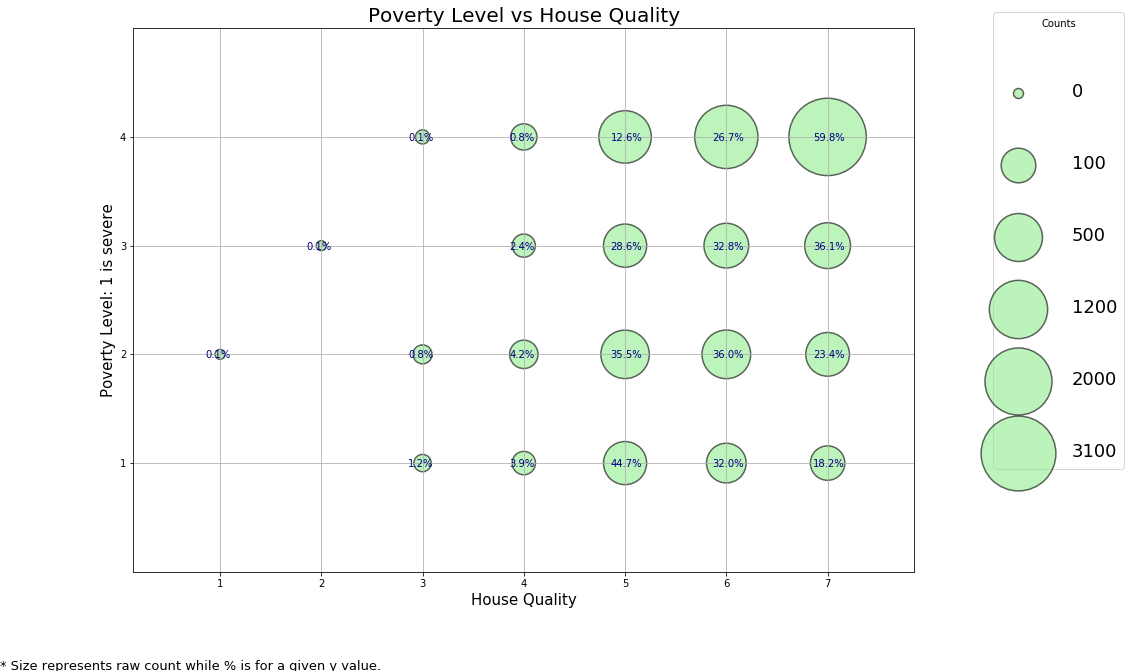

In [21]:
plot_categoricals('casa_calidad', 'Target', train)
plt.xlabel('House Quality', fontsize=15)
plt.ylabel('Poverty Level: 1 is severe', fontsize=15)
plt.title('Poverty Level vs House Quality', fontsize=20)

In [22]:
train = train.drop(train[(train['Target']>=3) & (train['casa_calidad']<=4)].index) 
train = train.drop(train[(train['Target']==2) & (train['casa_calidad']<2)].index) 

Text(0.5,1,'Poverty Level vs Luxury Goods')

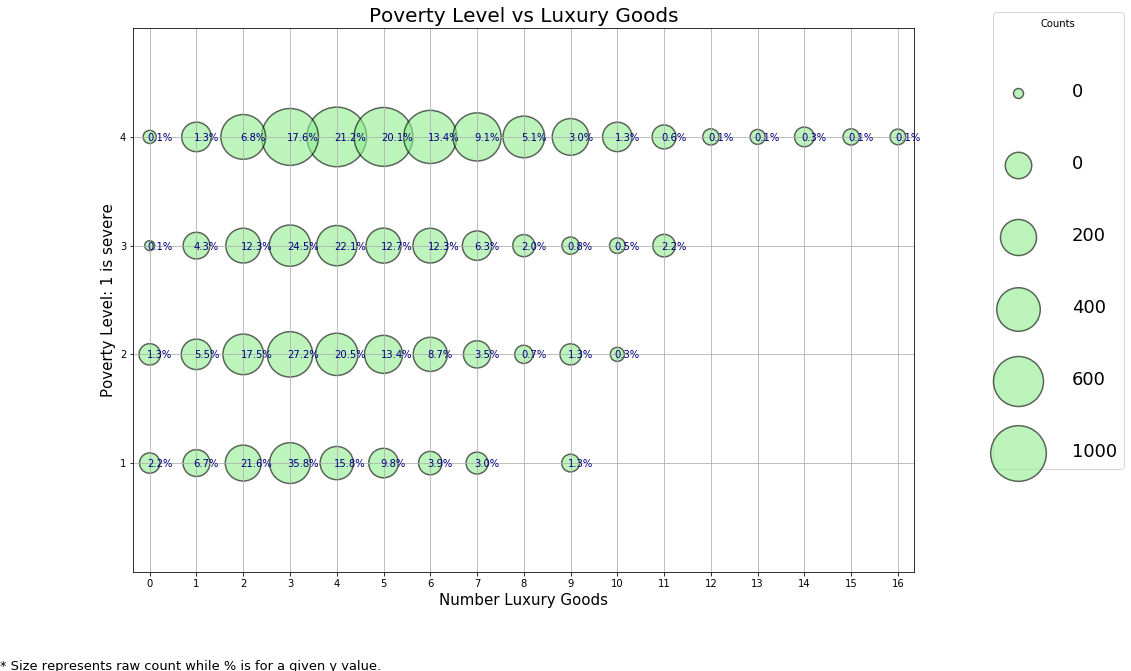

In [23]:
plot_categoricals('luxury', 'Target', train)
plt.xlabel('Number Luxury Goods', fontsize=15)
plt.ylabel('Poverty Level: 1 is severe', fontsize=15)
plt.title('Poverty Level vs Luxury Goods', fontsize=20)

In [24]:
train = train.drop(train[(train['Target']>=3) & (train['luxury']==0)].index) 
train = train.drop(train[(train['Target']<3) & (train['luxury']>8)].index) 

### Let's look now for features that are highly correlated with each other. Note that squared features will have incredibly high correlations with their un-squared counterparts. For that reason, we have separated the squared features and will not be looking at those at this point for that reason. 
### We will begin now at looking at correlations between 

Text(0.5,1,'Variables Correlated With Poverty Level')

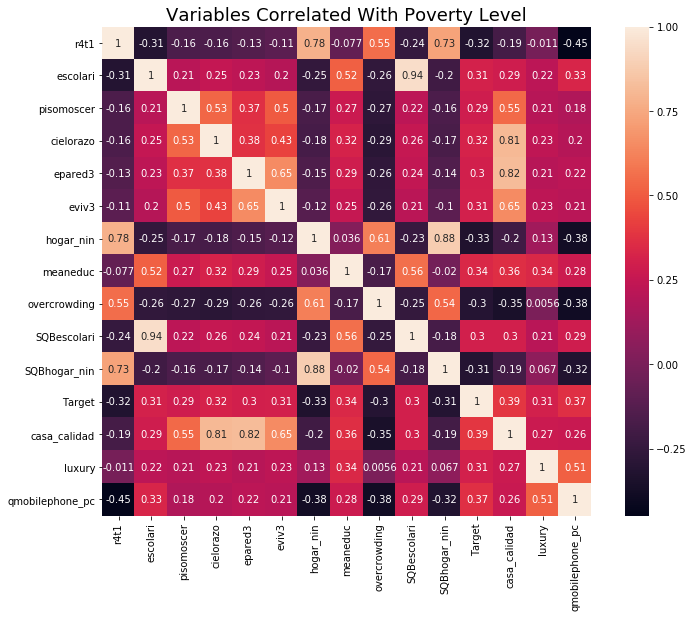

In [25]:
corr_train = train.corr()
highest_corr = corr_train.index[abs(corr_train["Target"])>0.29]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[highest_corr].corr(), square = True, annot = True)
plt.title('Variables Correlated With Poverty Level', fontsize=18)

### We notice that there are several very similar inicators for household size that are just about perfectly correlated, so we will drop them.

In [26]:
hh_ordered.remove('hogar_total')
hh_ordered.remove('tamhog')
hh_ordered.remove('r4t3')
train = train.drop(['hogar_total', 'tamhog', 'r4t3'], axis=1)

## 4.1.9 Get Dummies 

### We will need to convert all of the columns from ind_bool and hh_bool into a string, which will then allow us to create dummy variables.

In [28]:
for col in ind_bool:
    train[col] = pd.get_dummies(train[col].astype(str))

for col in hh_bool:
    train[col] = pd.get_dummies(train[col].astype(str))

In [29]:
mapping = {"yes": 1, "no": 0}
train['dependency'] = train['dependency'].replace(mapping).astype(np.float64)
train['edjefa'] = train['edjefa'].replace(mapping).astype(np.float64)
train['edjefe'] = train['edjefe'].replace(mapping).astype(np.float64)

In [30]:
# Exclude Target from training data set

Target = train['Target']
train = train.drop(['Target'], axis=1) 

## 4.1.10 Fix Skewness

In [31]:
from scipy.stats import norm, skew

num_feat = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[num_feat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print('There are {} variables to transform'.format(skewness.shape[0]))


Skew in numerical features: 

There are 144 variables to transform


In [32]:
from scipy.special import boxcox1p
lmbda = .15  # Hyperperameter to change around

for var in skewness.index:
    train[var] = boxcox1p(train[var], lmbda)

## 4.1.11 Scale Training Data

In [33]:
# Scale features
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_train_df = pd.DataFrame(scaler.fit_transform(train))
scaled_train_df.columns = train.columns

# 4.2 Model Selection

## 4.2.1 Functions for Visualizing Models and Determining F1 Score

In [34]:
# Initial train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_train_df, Target, test_size=.33, random_state=42)

In [35]:
# Code for multilevel confusion matrix plot by Will Koehrsen
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [36]:
## Function to determine f1 scores given a model along with confusion matrix. Note we won't use this function 
## for logistic regression to show other diagnostics along the way. 
from sklearn.metrics import accuracy_score, f1_score
def give_f1(model):
    model.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    y_pred_train2 = list(y_pred_train)
    y_train2 = list(y_train)


    y_pred_test2 = list(y_pred_test)
    y_test2 = list(y_test)
    
    f1 = f1_score(y_test2, y_pred_test2, average='macro') 
    print(f1)
    
    # creating a confusion matrix 
    model_predictions = model.predict(X_test)  
    cm = confusion_matrix(y_test, model_predictions) 

    cm = confusion_matrix(y_test, y_pred_test2)

    plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                          title = 'Poverty Confusion Matrix')
 

## 4.2.2 Use logistic classifier to determine most important variables

In [37]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)



In [1]:
feature_names = list(scaled_train_df.columns)
feat_importances = pd.Series(logreg.coef_[0], index=scaled_train_df.columns)
plt.subplots(figsize=(12,9))

fig = feat_importances.nlargest(20).plot(kind='barh')
plt.title('Most Important Variables', fontsize=20)

plt.xlabel('Normalized Importance', fontsize=15)
plt.ylabel('Feature', fontsize=15)


NameError: name 'scaled_train_df' is not defined

## Subset to only most important features

In [39]:
##best_features = list(pd.DataFrame(feat_importances.nlargest(100)).index)
#scaled_train_df2 = scaled_train_df[best_features]

# Redefine train test split
#X_train, X_test, y_train, y_test = train_test_split(scaled_train_df2, Target, test_size=.20, random_state=12)

### Print accuracy

In [40]:
print("Train acc: {}".format(accuracy_score(y_train, y_pred_train)))
print("Test acc: {}".format(accuracy_score(y_test, y_pred_test)))

Train acc: 0.7062638405567858
Test acc: 0.7026332691072575


In [41]:
y_pred_test2 = list(y_pred_test)
y_test2 = list(y_test)

In [42]:
f1_score(y_test2, y_pred_test2, average='macro') 

0.4813951864181796

### Graph to show change in precision and recall 

In [43]:
from sklearn.metrics import precision_recall_fscore_support
train_prediction_probabilities = logreg.predict_proba(X_train)
test_prediction_probabilities = logreg.predict_proba(X_test)


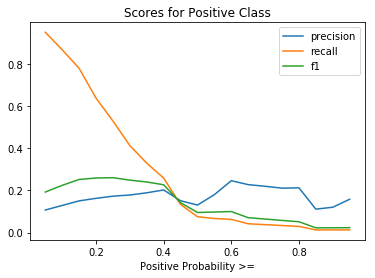

In [44]:
# From Tyler Folkman
from sklearn.metrics import precision_recall_curve, average_precision_score

precisions, recalls, f1s = [], [], []
cutoffs = np.arange(0.05, 1, 0.05)
for cutoff in cutoffs:
    binary_test_predictions = [x[1] >= cutoff for x in test_prediction_probabilities]
    p, r, f1, s = precision_recall_fscore_support(y_test, binary_test_predictions)
    precisions.append(p[1])
    recalls.append(r[1])
    f1s.append(f1[1])
    
plt.plot(cutoffs, precisions, label='precision')
plt.plot(cutoffs, recalls, label='recall')
plt.plot(cutoffs, f1s, label='f1')
plt.xlabel("Positive Probability >=")
plt.title("Scores for Positive Class")
plt.legend()
    

In [45]:
cutoffs[np.argmax(f1s)]

0.25

Confusion matrix, without normalization
[[  91   61   11   77]
 [  38  208   36  248]
 [  18   54   47  268]
 [  15   75   25 1842]]


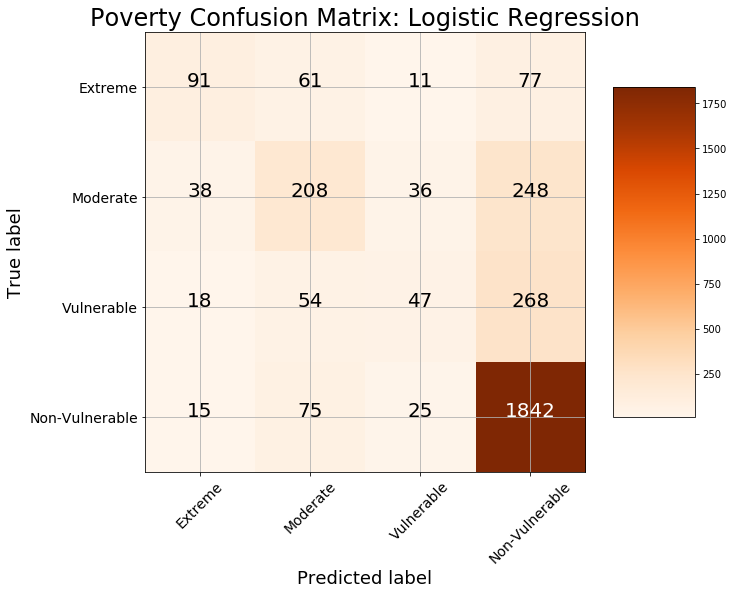

In [46]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test2)

plot_confusion_matrix(cm, classes = ['Extreme', 'Moderate', 'Vulnerable', 'Non-Vulnerable'],
                      title = 'Poverty Confusion Matrix: Logistic Regression')

### Let's now put this all (or at least the important parts) together using the give_f1 function to determine how well SVM predicts the classes. We will begin by defining the gridsearch algorithm.

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [48]:
def gridsearching(model):
    model.fit(X_train, y_train)
    print("Best Params: {}".format(model.best_params_))
    y_pred_train = model.predict(X_train)
    print("Train F1: {}".format(f1_score(y_train, y_pred_train, average="macro")))
    print("Test Classification Report:")
    y_pred_test = model.predict(X_test)
    print(classification_report(y_test, y_pred_test))
    print("Train Accuracy: {}\tTest accuracy: {}".format(accuracy_score(y_train, y_pred_train),
                                                     accuracy_score(y_test, y_pred_test)))

In [49]:
logreg = LogisticRegression()
model = GridSearchCV(logreg, {'penalty': ['l1', 'l2']})
gridsearching(model)


Best Params: {'penalty': 'l2'}
Train F1: 0.4887664401631357
Test Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.38      0.45       240
           2       0.52      0.39      0.45       530
           3       0.39      0.12      0.19       387
           4       0.76      0.94      0.84      1957

   micro avg       0.70      0.70      0.70      3114
   macro avg       0.56      0.46      0.48      3114
weighted avg       0.66      0.70      0.66      3114

Train Accuracy: 0.7062638405567858	Test accuracy: 0.7026332691072575


0.4813951864181796
Confusion matrix, without normalization
[[  91   61   11   77]
 [  38  208   36  248]
 [  18   54   47  268]
 [  15   75   25 1842]]


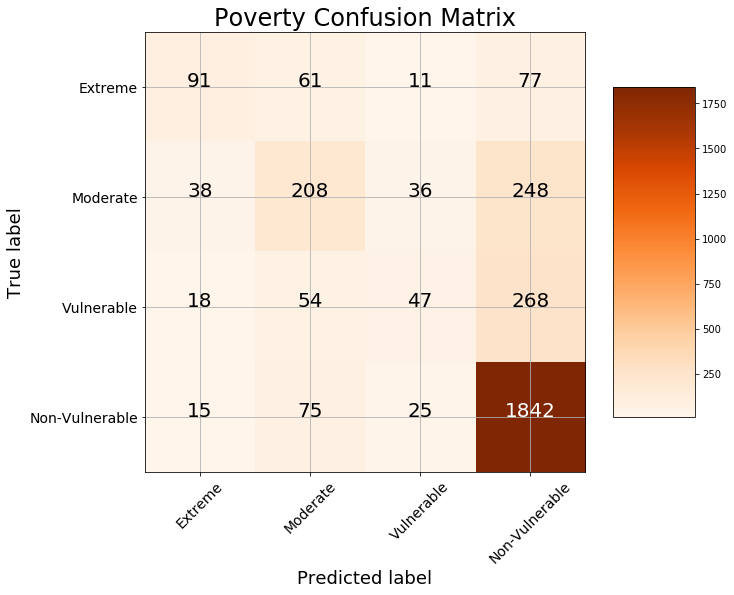

In [50]:
logreg = LogisticRegression(penalty='l2')
give_f1(logreg)

## 4.2.3 SVM

0.4472693001917334
Confusion matrix, without normalization
[[  72   67    9   92]
 [  40  186   30  274]
 [  18   51   38  280]
 [   8   58   24 1867]]


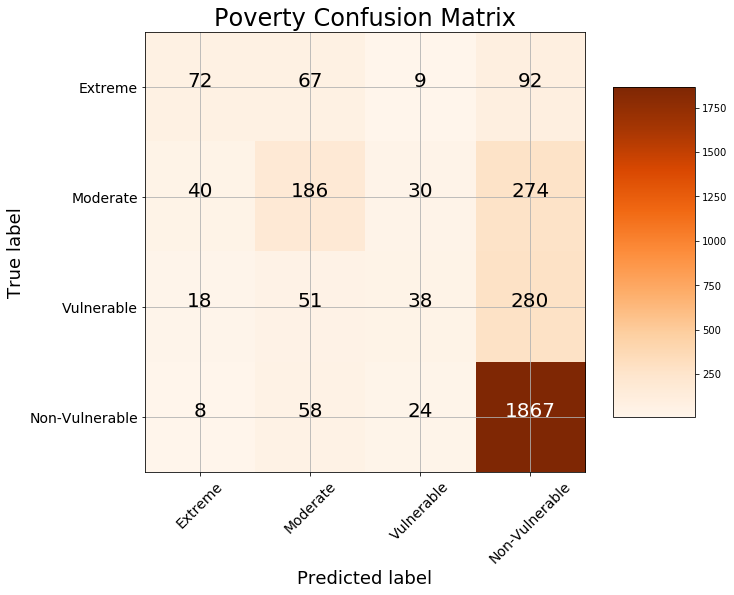

In [51]:
from sklearn import svm
SVM = svm.LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

give_f1(SVM)

## 4.2.4 Naive Bayes Estimator

0.14902675544061644
Confusion matrix, without normalization
[[  29    9  197    5]
 [  25   21  482    2]
 [   3    4  377    3]
 [  19    5 1821  112]]


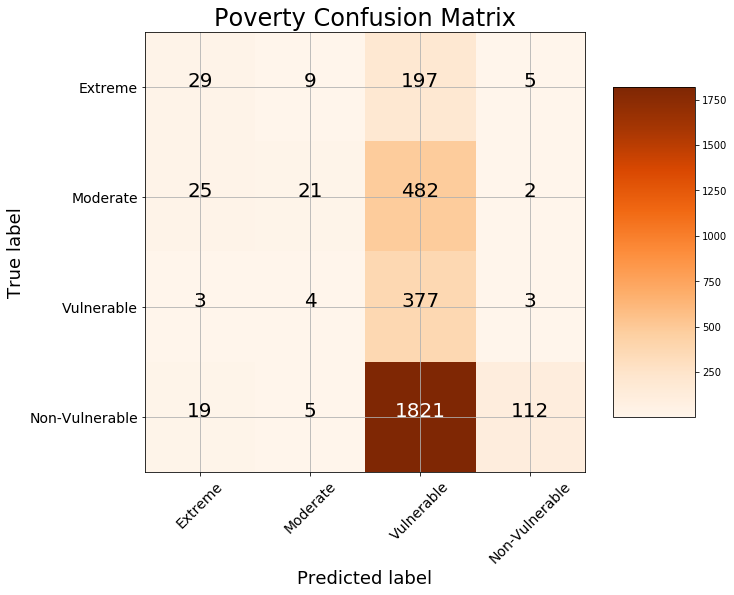

In [52]:
from sklearn.naive_bayes import GaussianNB 

give_f1(GaussianNB())

## 4.2.5 Decision Tree Classifier

0.415046754693676
Confusion matrix, without normalization
[[  34  105    0  101]
 [  19  248    5  258]
 [   0   96   30  261]
 [   5  109    0 1843]]


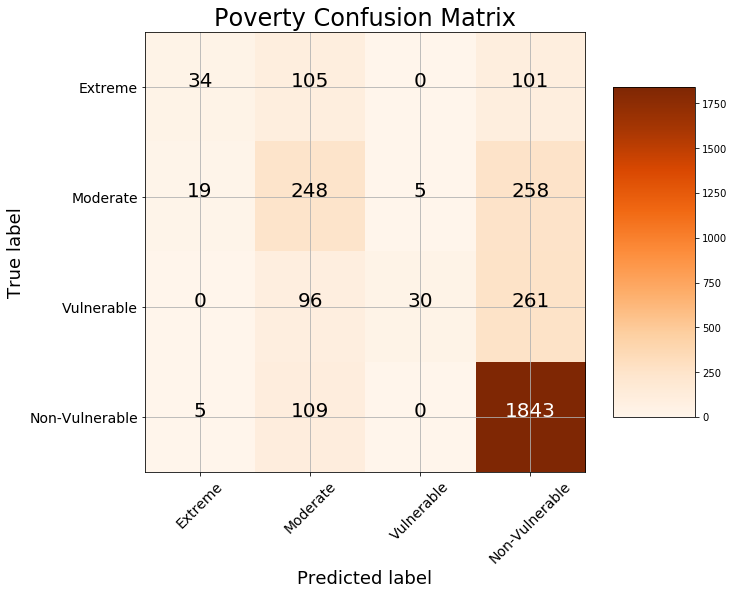

In [54]:
from sklearn.tree import DecisionTreeClassifier 
Decision_Tree = DecisionTreeClassifier(max_depth = 5)
give_f1(Decision_Tree)

## 4.2.6 Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier

Random_Forest = RandomForestClassifier()
model = GridSearchCV(Random_Forest, {'max_depth': [4,5,6], 'n_estimators': [9,10,11,12]}, scoring="f1_macro")
gridsearching(model)


Best Params: {'max_depth': 6, 'n_estimators': 9}
Train F1: 0.4106573095759944
Test Classification Report:
              precision    recall  f1-score   support

           1       0.79      0.17      0.29       240
           2       0.56      0.32      0.40       530
           3       0.95      0.05      0.09       387
           4       0.70      0.98      0.82      1957

   micro avg       0.69      0.69      0.69      3114
   macro avg       0.75      0.38      0.40      3114
weighted avg       0.71      0.69      0.62      3114

Train Accuracy: 0.6991458399240746	Test accuracy: 0.6894669235709698


0.4671002367923228
Confusion matrix, without normalization
[[  58   54    0  128]
 [   0  210    0  320]
 [   3   37   37  310]
 [   2   38    0 1917]]


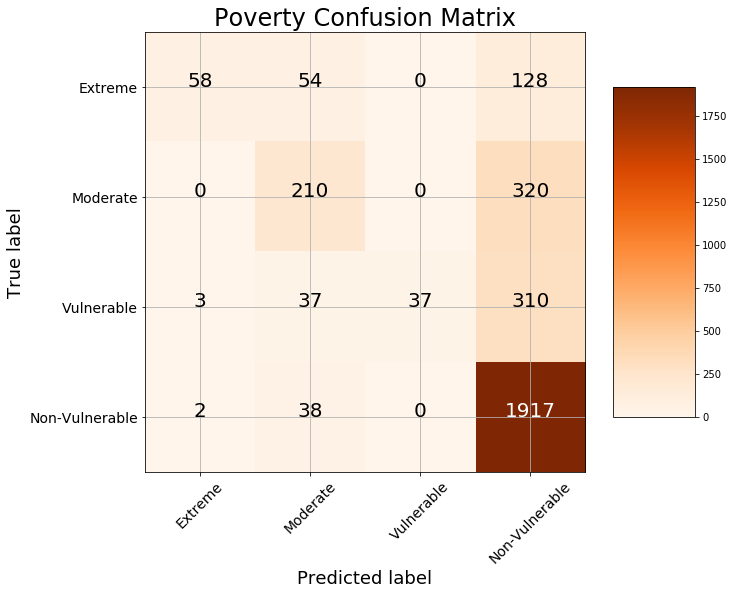

In [56]:
Random_Forest = RandomForestClassifier(max_depth = 6, n_estimators=11)
give_f1(Random_Forest)

## 4.2.7 K Nearest Neighbors (Best Model)

0.6800953604114606
Confusion matrix, without normalization
[[ 153   24   12   51]
 [  26  331   29  144]
 [  17   41  195  134]
 [  41   90   74 1752]]


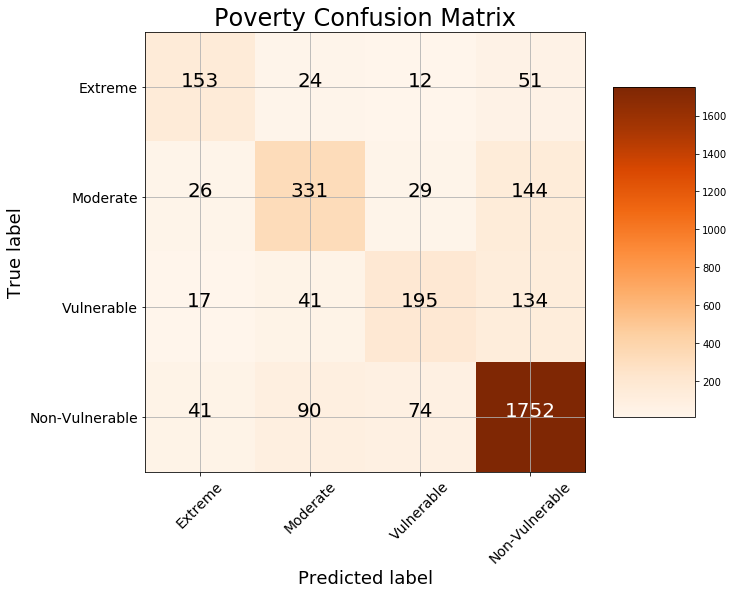

In [57]:
from sklearn.neighbors import KNeighborsClassifier 

KNearest = KNeighborsClassifier(n_neighbors=4)
give_f1(KNearest)

#It took too long on my computer to do the gridsearching for K Nearest Neighbors, so we'll
# skip this part
#KNearest_gridsearch = GridSearchCV(KNearest, {'n_neighbors': [3,4,5,6,7]}, scoring="f1_weighted")
#gridsearching(KNearest_gridsearch)

# Best F1 (Macro): 0.68

In [58]:
from IPython.display import HTML
HTML('<img src="https://media.giphy.com/media/udmx3pgdiD7tm/giphy.gif">')
